In [1]:
import pandas as pd
import json
import requests
import math
import matplotlib.pylab as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from scipy.stats import norm as nrm, mstats

from itertools import groupby
from datetime import datetime as dt

from prep import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\P276495\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['types', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def mk_test(x, alpha = 0.05):  
    """
    
    http://michaelpaulschramm.com/simple-time-series-trend-analysis/
    
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05) 
    """
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
            z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-nrm.cdf(abs(z))) # two tail test
    h = abs(z) > nrm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

# Functions for getting SonarQube timemachine metrics

In [3]:
def get_sonarqube_timemachine_metrics_DataFrame(ghp):
    json_data = get_sonarqube_timemachine_metrics(ghp)
    cells = get_cells(json_data)
    return transform_timemachine_metrics_to_series(cells)

def get_sonarqube_timemachine_metrics(ghp):
    return get_rest_response(ghp.timemachine_metrics_url + METRICS)

def get_cells(json_data):
    return json_data[0]['cells']  # cells - metric values

def get_colls(json_data):
    return json_data[0]['cols']  # cols - Metrcs

def get_no_of_versions(cells):
    return len(cells)

def transform_timemachine_metrics_to_series(cells):
    date_range_index = get_date_range_index_for_timemachine_metrics(cells)
    df = pd.DataFrame(index=date_range_index)
    for metric_index in range(0, metrics_list_length):
        s = pd.Series(index=date_range_index)
        for item in cells:
            s[pd.Timestamp(item.get('d')).date()] = item.get('v')[metric_index]
        df[METRICS_LIST[metric_index]] = s
    return df


def get_date_range_index_for_timemachine_metrics(cells):
    project_dates = get_project_dates(cells)
    min_project_date = min(project_dates)
    max_project_date = max(project_dates)
    return pd.date_range(start=min_project_date.date(), end=max_project_date.date(), freq='D')

def get_project_dates(cells):
    dates = []
    for item in cells:
        dates.append(pd.Timestamp(item.get('d')))
    return dates

# Perform the analysis

In [4]:
# repos = get_repos()
# for ghp in repos:
#     print(ghp.repo)
#     timemachine_metrics = get_sonarqube_timemachine_metrics_DataFrame(ghp)
#     timemachine_metrics = timemachine_metrics.fillna(method='ffill')
#     timemachine_metrics['normalized_td'] = timemachine_metrics['sqale_index']/timemachine_metrics['ncloc']
#     issues = timemachine_metrics[['violations','blocker_violations','critical_violations','major_violations','minor_violations','info_violations','open_issues']]
#     smells_bugs_classes = timemachine_metrics[['code_smells','bugs','classes']]
#     lines_sqale = timemachine_metrics[['lines','ncloc','sqale_index']]
    
#     complexity = timemachine_metrics[['complexity','class_complexity','file_complexity','function_complexity']]
#     documentation = timemachine_metrics[['comment_lines','comment_lines_density']]
#     duplications = timemachine_metrics[['duplicated_blocks','duplicated_files','duplicated_lines','duplicated_lines_density']]
#     maintainability = timemachine_metrics[['code_smells','sqale_index','sqale_debt_ratio']]
#     reliability = timemachine_metrics[['bugs','reliability_remediation_effort']]
#     security = timemachine_metrics[['vulnerabilities','security_remediation_effort']]
#     size = timemachine_metrics[['classes','directories','files','lines','ncloc','functions','statements']]
    
#     plot(complexity)
#     plot(documentation)
#     plot(duplications)
#     plot(issues)
#     plot(maintainability)
#     plot(reliability)
#     plot(security)
#     plot(size)
    
#     plot(smells_bugs_classes)
#     plot(lines_sqale)
#     plt.figure()
#     plot(timemachine_metrics['normalized_td'])
    
#     timemachine_metrics = timemachine_metrics[timemachine_metrics.index.weekday==6]
#     res = sm.tsa.seasonal_decompose(timemachine_metrics['normalized_td'])
#     resplot = res.plot()
#     resplot.show()

In [5]:
def get_no_loops(response):
    total = response['total']
    ps = response['ps']
    no_of_loops = math.ceil(response['total'] / response['ps']) + 1
    return total, ps, no_of_loops

def build_issues_url(issues_url, type, severity):
    return issues_url + '&types=' + type + '&severities=' + severity

def ddd(ghp):
    response = get_rest_response(ghp.issues_url)
    total, ps, no_of_loops = get_no_loops(response)
    
    for p in range(2, no_of_loops):
        print (get_rest_response(ghp.issues_url + '&p=' + str(p))['issues'])
        print(ghp.issues_url + '&p=' + str(p))

# General functions
def get_rest_response(rest_url):
    response = requests.get(rest_url)
    return json.loads(response.text)

def jsonDate_to_date(date):
    return datetime.datetime.fromtimestamp(date / 1e3)

def get_date(date):
    return pd.Timestamp(date).date()

def plot(plt):
    plt.plot(figsize=(15,10))

In [6]:
# severities = 'INFO,MINOR,MAJOR,CRITICAL,BLOCKER'.split(',')
# types = 'BUG,VULNERABILITY,CODE_SMELL'.split(',')
# resolved = 'false'

# repos = get_repos()
# for ghp in repos:
#     print(ghp.repo)
#     project_rules = {}
#     all_project_rules = {}
#     for type in types:
#         for severity in severities:
#             issues_url = build_issues_url(ghp.issues_url, type, severity) + '&resolved=' + resolved
#             response = get_rest_response(issues_url)
#             total, ps, no_of_loops = get_no_loops(response)
#             issues = response['issues']
#             for issue in issues:
#                 project_rules[issue['rule']] = project_rules.get(issue['rule'], 0) + 1
#                 all_project_rules[issue['rule']] = all_project_rules.get(issue['rule'], 0) + 1
#             for p in range(2, no_of_loops):
#                 response = get_rest_response(issues_url + '&p=' + str(p))
#                 issues = response['issues']
#                 for issue in issues:
#                     project_rules[issue['rule']] = project_rules.get(issue['rule'], 0) + 1
#                     all_project_rules[issue['rule']] = all_project_rules.get(issue['rule'], 0) + 1
#         print(type)
#         print(project_rules)
#         project_rules = {}
#     print('all_project_rules')
#     print(all_project_rules)

In [7]:
# def build_issues_url(issues_url, parameter_key, parameter_value):
#     return issues_url + '&' + parameter_key + '=' + parameter_value

# def get_issues_url_by_type(issues_url, type):
#     return build_issues_url(issues_url, 'types', type)
    
# def get_issues_url_by_severity(issues_url, severity):
#     return build_issues_url(issues_url, 'severities', severity)
    
# def get_issues_url_by_resolution(issues_url, resolution):
#     return build_issues_url(issues_url, 'resolutions', resolution)

C:\Users\P276495\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


sling ('decreasing', True, 0.0, -20.287406625419152)


C:\Users\P276495\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


zookeeper ('decreasing', True, 0.0, -21.241297846216664)
directory-shared ('decreasing', True, 0.0, -20.999336180026372)
cayenne ('decreasing', True, 0.0076433962194168981, -2.6674293291290647)
poi ('decreasing', True, 0.0, -14.060974127837023)
nutch ('decreasing', True, 0.0, -17.18344087054054)
commons-lang ('decreasing', True, 0.0, -10.018365650888464)
batik ('decreasing', True, 0.0, -18.002388396565895)
maven ('decreasing', True, 6.1195987125062246e-05, -4.0081510094671859)
commons-cli ('increasing', True, 0.011004608228581292, 2.5425524538227582)
pdfbox ('decreasing', True, 0.0, -17.916583298988535)
aries ('decreasing', True, 0.0, -21.532127157775843)
elasticsearch ('decreasing', True, 0.0, -15.473245128565463)
jmeter ('decreasing', True, 0.0, -20.32063786026065)
retrofit ('increasing', True, 0.0, 17.333934040899354)
spring-framework ('decreasing', True, 0.0, -15.373942084699895)
orion.server ('no trend', False, 0.54519618243988832, -0.6049741353786241)
egit ('decreasing', True, 0.

C:\Users\P276495\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


spring-security-oauth ('increasing', True, 0.0, 14.381571027605219)
sqoop ('increasing', True, 1.4552661653510768e-07, 5.2581312847290906)
flume ('decreasing', True, 0.041705745447299769, -2.0364444536995112)
kafka ('decreasing', True, 9.7455377101596241e-13, -7.1340688105496062)
giraph ('increasing', True, 3.8214284352466876e-06, 4.6208652961764987)
spring-roo ('increasing', True, 0.0, 20.85736602708527)
tomcat ('decreasing', True, 0.0, -23.349422768080267)
okhttp ('increasing', True, 0.0, 13.275180760360998)
crunch ('decreasing', True, 1.2745360322696797e-13, -7.4088266122110822)
auto ('increasing', True, 6.1983138810006722e-05, 4.0051309335203626)
jclouds ('decreasing', True, 0.0, -13.93492258380342)
struts ('decreasing', True, 0.0, -20.431401295441738)
cxf ('increasing', True, 4.936051567483446e-13, 7.2270626107627525)
tomcat80 ('decreasing', True, 0.0, -20.239601074883904)
nifi ('increasing', True, 0.0, 12.048862708368846)


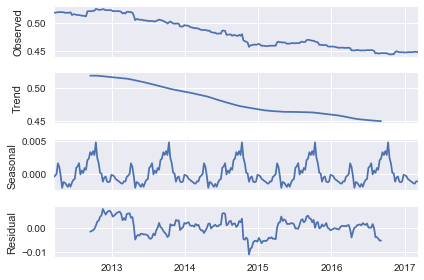

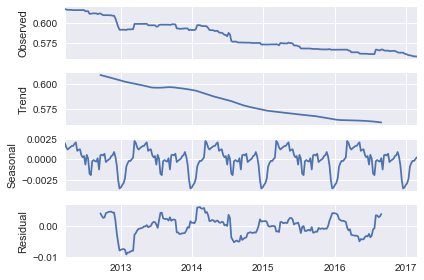

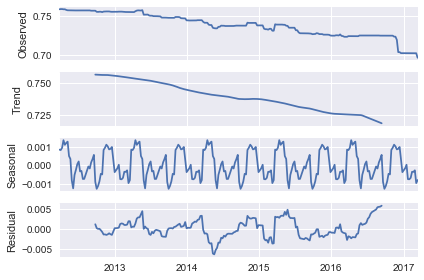

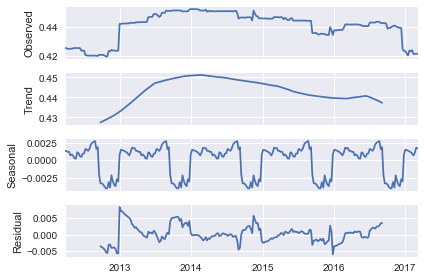

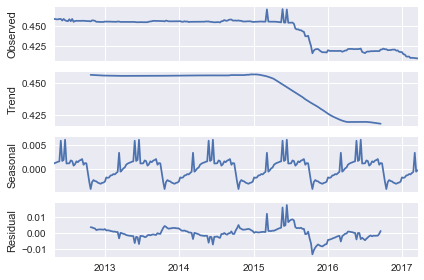

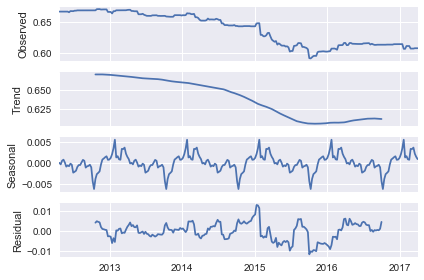

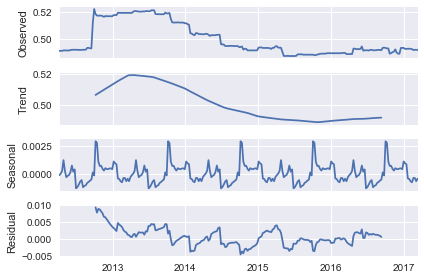

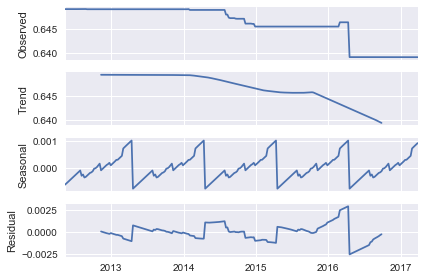

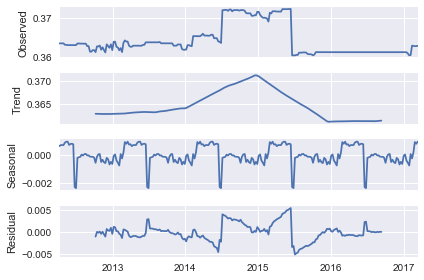

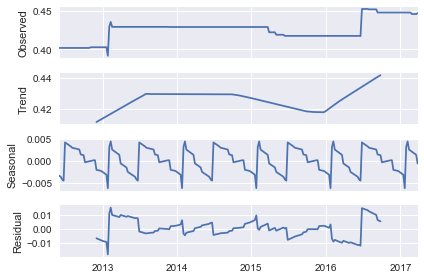

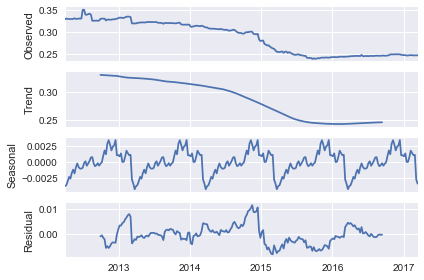

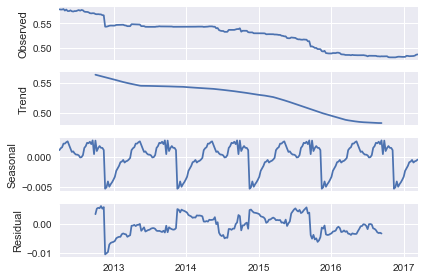

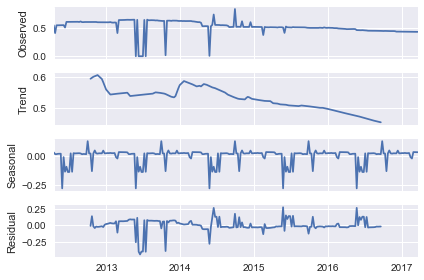

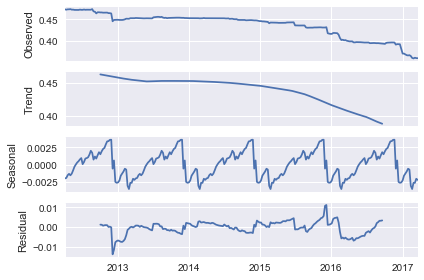

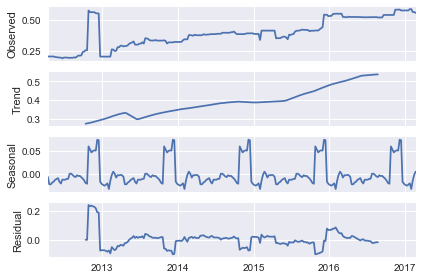

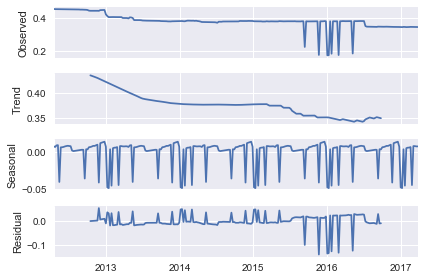

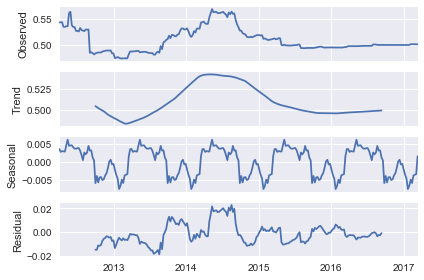

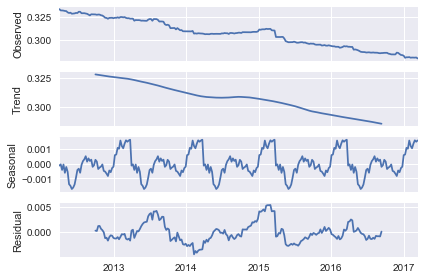

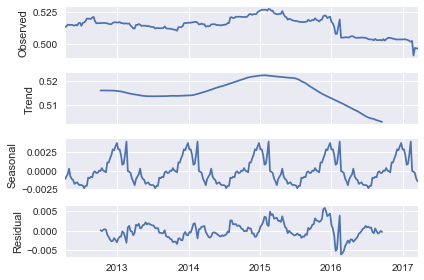

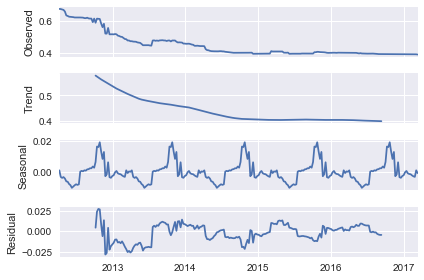

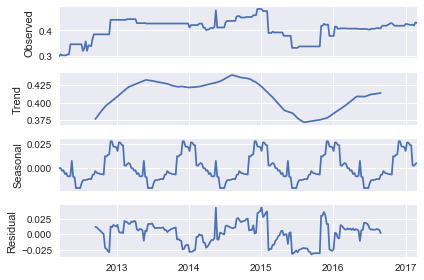

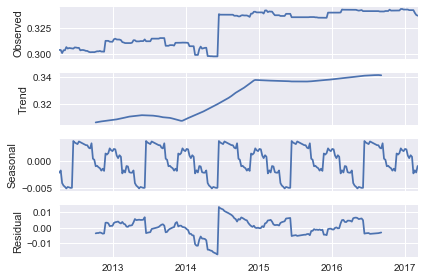

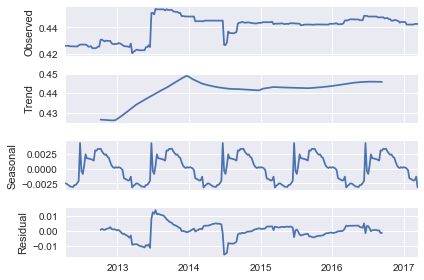

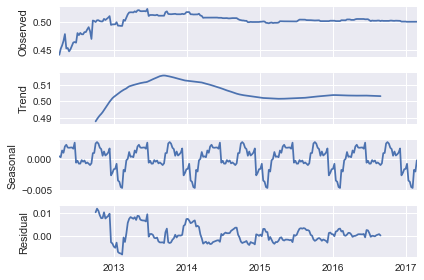

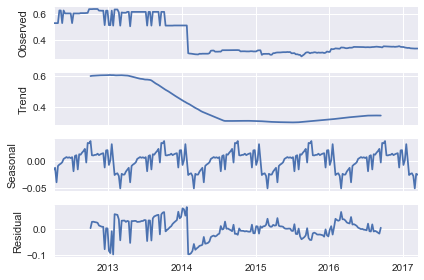

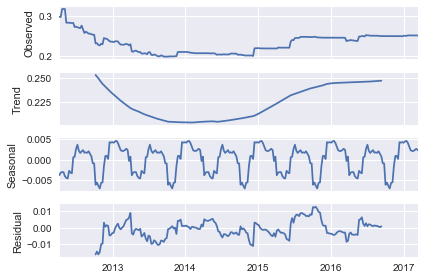

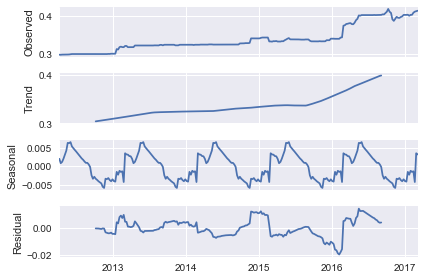

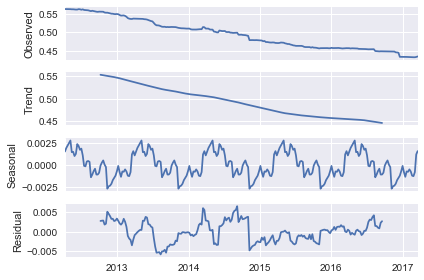

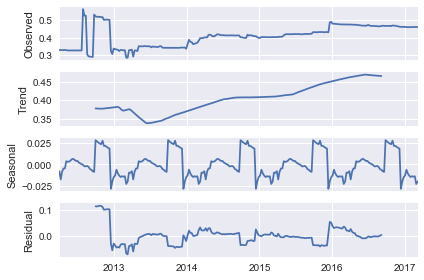

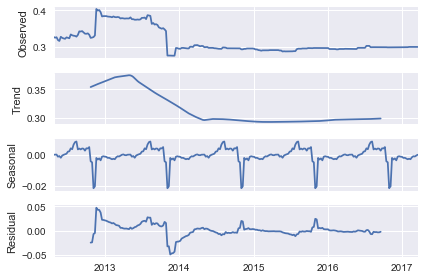

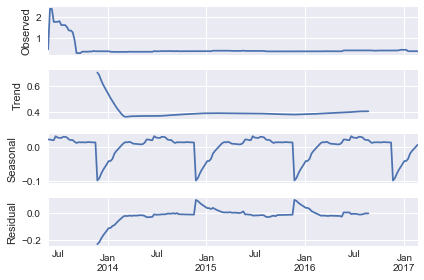

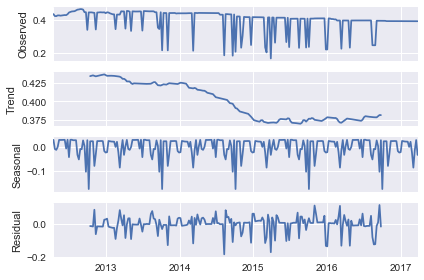

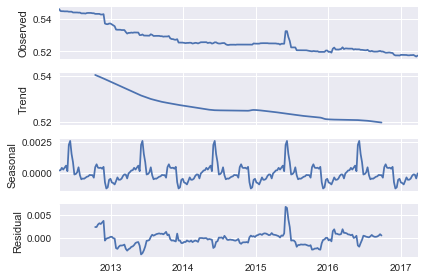

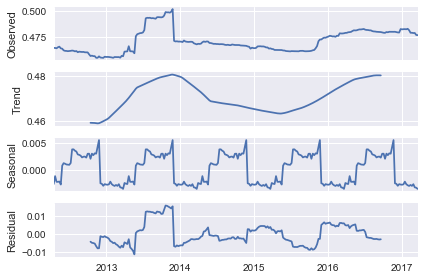

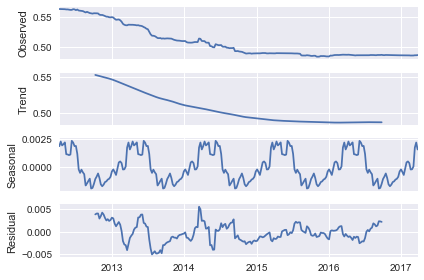

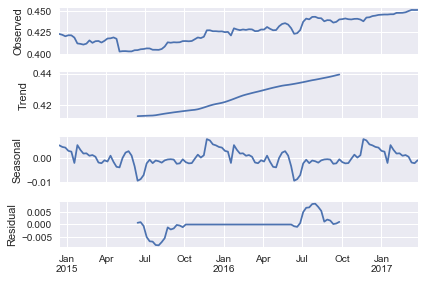

In [8]:
repos = get_repos()
for ghp in repos:
#     print(ghp.repo)
    timemachine_metrics = get_sonarqube_timemachine_metrics_DataFrame(ghp)
    timemachine_metrics = timemachine_metrics.fillna(method='ffill')
    timemachine_metrics['normalized_td'] = timemachine_metrics['sqale_index']/timemachine_metrics['ncloc']
#     plot(timemachine_metrics[['normalized_td', 'sqale_index']])
    timemachine_metrics = timemachine_metrics[timemachine_metrics.index.weekday==6]
#     plot(timemachine_metrics['normalized_td'])
    res = sm.tsa.seasonal_decompose(timemachine_metrics['normalized_td'])
    print(ghp.repo, mk_test(timemachine_metrics['normalized_td'],alpha=0.05))
    resplot = res.plot()
    resplot.show()
#     mk_test(timemachine_metrics['normalized_td'],alpha=0.05)